In [34]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import seaborn as sns
import scipy as sci
import matplotlib.pyplot as plt
import scikit_posthocs as sci_posthocs

import analysis as ana

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_colwidth', 100)

In [4]:
import matplotlib as mpl
from matplotlib import rc

rc('text', usetex=False)
font = {#'family':'CMU Serif', 
        #'sans-serif':['Helvetica'],
        'size': 11}
#mpl.rc('font', **font)

# Preparation of Dataframe

In [5]:
path = '../../earlypsychosis/data/behavior/Package_1192721/'

In [6]:
features = pd.read_csv('../features_cog_updated.csv')
#features = pd.read_csv('../features_cog.csv')
features['file'] = features['file'].str.strip()
features['item'] = features['item'].str.strip()
len(features)

76

In [91]:
features

,file,item,cat,scale,desc
0,er4001,er40_c_cr,c,logscale,Correct Responses
1,er4001,er40_c_rtcr,c,logscale,Correct Responses Median Response Time (ms)
2,er4001,er40_c_ang,c,logscale,Correct Anger Identifications
3,er4001,er40_c_fear,c,logscale,Correct Fear Identifications
4,er4001,er40_c_hap,c,logscale,Correct Happy Identifications
5,er4001,er40_c_noe,c,logscale,Correct Neutral Identifications
6,er4001,er40_c_sad,c,logscale,Correct Sad Identifications
7,acpt01,auditory_t4,c,logscale,Total Q3A-Block : %Hits
8,acpt01,auditory_t5,c,logscale,Total Q3A-Block : RT (ms)
9,acpt01,auditory_t9,c,logscale,Total QA-Block : %Hits


In [7]:
socdem = pd.read_csv(path + 'socdem01.txt', sep="\t")
ses = pd.read_csv(path + 'ses01.txt', sep="\t")

## Description

In [8]:
df_description = pd.DataFrame()
feature_description = features.drop(index=[71,72,73,74,75])

In [9]:
df_description["interview_age"] = [socdem['interview_age'].iat[0]]
df_description["sex"] = [socdem['sex'].iat[0]]
df_description["sestot"] = [ses['sestot'].iat[0]]
df_description["mot_edscale"] = [ses['mot_edscale'].iat[0]]

for file, columns in feature_description.groupby('file'):
    columns = [col.strip() for col in list(columns.item)]
    data = pd.read_csv(path + file + '.txt', sep="\t")
    data = data[columns] #selecting relevant feature colums
    data = data.add_prefix(file + '_')
    
    for column in data:
        df_description[column] = [data[column].iat[0]]

In [10]:
df_description

,interview_age,sex,sestot,mot_edscale,acpt01_auditory_t4,acpt01_auditory_t5,acpt01_auditory_t9,acpt01_auditory_t10,acpt01_auditory_t14,acpt01_auditory_t15,cgi01_gaf2a,cgi01_gaf2b1,cgi01_gaf2b2,cgi01_gaf2c,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,dccs01_acc,dccs01_rt,dccs01_nih_dccs_ageadjusted,deldisk01_auc_200,deldisk01_auc_40000,er4001_er40_c_cr,er4001_er40_c_rtcr,er4001_er40_c_ang,er4001_er40_c_fear,er4001_er40_c_hap,er4001_er40_c_noe,er4001_er40_c_sad,flanker01_acc,flanker01_rt,flanker01_nih_flanker_ageadjusted,lswmt01_nih_tlbx_tscore,lswmt01_nih_tlbx_agegencsc,lswmt01_nih_tlbx_fctsc,lswmt01_tbx_ls,orrt01_read_acss,orrt01_read_fcts,pcps01_nih_tlbx_fctsc,pcps01_nih_patterncomp_ageadjusted,prang01_anger_ts,predd01_edd_rs,prsi01_soil_rs,psm01_nih_picseq_ageadjusted,pss01_pss_distress_rs,self_effic01_nih_tlbx_rawscore,tlbx_emsup01_nih_tlbx_rawscore,tlbx_friend01_nih_tlbx_rawscore,tlbx_perhost01_nih_tlbx_rawscore,tlbx_rej01_pr_score,tlbx_wellbeing01_tlbxpa_ts,tpvt01_tlbx_readncorr,tpvt01_lavoc_screen,tpvt01_tpvt_acss,tpvt01_tpvt_fcts,wasi201_ss_blockdesigntscoreperf4,wasi201_ss_vocabularytscoreverbal4,wasi201_ss_vocabularytscore2,wasi201_ss_matrixreasoningtscoreperf4,wasi201_ss_matrixreasoningtscore2,wasi201_ss_similaritiestscoreverbal4,wasi201_sumstscores_verbal4subtest,wasi201_sumstscores_perf4subtest,wasi201_sumstscores_total4subtest,wasi201_sumstscores_total2subtest,wasi201_iqscores_verbsumtscores,wasi201_iqscores_verbiq,wasi201_iqscores_verbpercentile,wasi201_iqscores_verbconfintervalfrom,wasi201_iqscores_verbconfintervalto,wasi201_iqscores_perfsumtscores,wasi201_iqscores_perfiq,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq,ymrs01_ymrstot
0,Age in months at the time of the interview/test/sampling/imaging.,Sex of subject at birth,Socio-Economic Status (SES),Mother Educational Scale,Total Q3A-Block : %Hits,Total Q3A-Block : RT,Total QA-Block : %Hits,Total QA-Block : RT,Total Q1AINT-Block : %Hits,Total Q1AINT-Block : RT,Participant and clinician report-Symptom Scale Score,Participant and clinician report-Occupational Functioning Scale Score,Participant and clinician report-Occupation,Participant and clinician report-Social Functioning Scale Score,Fluid Cognition Composite Score unadjusted,Crystal Cognition Composite Score unadjusted,Accuracy,Reaction Time,Age Adjusted scaled score for DCCS subtest,Area Under the Curve for Delay Amount $200,Area Under the Curve for Delay Amount $40000,Correct Responses,Correct Responses Median Response Time (ms),Correct Anger Identifications,Correct Fear Identifications,Correct Happy Identifications,Correct Neutral Identifications,Correct Sad Identifications,Accuracy,Reaction Time,Age Adjusted scaled score for Flanker subtest,T-score,Age-Gender-Corrected T-score,Fully-Corrected T-Score,List Sort Test total score,Reading test Age-Corrected Standard Score,Reading test Fully Corrected T-score,Fully-Corrected T-Score,Age Adjusted scaled score for PatternComp subtest,Anger T score,Emotional Distress Depression raw score,Social Isolation raw score,Age Adjusted scaled score for PicSeq subtest,PSS Distress raw score,RawScore,RawScore,RawScore,RawScore,Peer Rejection Score,Positive affect t-score,English Reading Number Correct,Vocabulary Starting theta based on age/education,TPVT age-corrected standard score,TPVT fully corrected T-score,Block Design T - Score Performance - 4 Subtest,Vocabulary T - Score Verbal - 4 Subtest,Vocabulary T - Score - 2 Subtest,Matrix Reasoning T - Score Performance - 4 Subtest,Matrix Reasoning T - Score - 2 Subtest,Similarities T - Score Verbal - 4 Subtest,Verbal - Score - 4 Subtest,Performance - Score - 4 Subtest,Total - Score - 4 Subtest,Total - Score - 2 Subtest,Verbal Sum of T - Scores,Verbal IQ,Verbal Percentile,Verbal Confidence Interval - From,Verbal Confidence Interval - To,Performance Sum of T - Scores,Performance IQ,Total Raw Score - Vocabulary,Total Raw Score - Matrix Reasoning,Full 2 IQ,YMRS Tot

In [11]:
df_description = df_description.T
df_description['included'] = [0]*75

In [13]:
print(df_description.to_latex(index=True))  

\begin{tabular}{llr}
\toprule
 & 0 & included \\
\midrule
interview_age & Age in months at the time of the interview/test/sampling/imaging. & 0 \\
sex & Sex of subject at birth & 0 \\
sestot & Socio-Economic Status (SES) & 0 \\
mot_edscale & Mother Educational Scale & 0 \\
acpt01_auditory_t4 & Total Q3A-Block : %Hits & 0 \\
acpt01_auditory_t5 & Total Q3A-Block : RT & 0 \\
acpt01_auditory_t9 & Total QA-Block : %Hits & 0 \\
acpt01_auditory_t10 & Total QA-Block : RT & 0 \\
acpt01_auditory_t14 & Total Q1AINT-Block : %Hits & 0 \\
acpt01_auditory_t15 & Total Q1AINT-Block : RT & 0 \\
cgi01_gaf2a & Participant and clinician report-Symptom Scale Score & 0 \\
cgi01_gaf2b1 & Participant and clinician report-Occupational Functioning Scale Score & 0 \\
cgi01_gaf2b2 & Participant and clinician report-Occupation & 0 \\
cgi01_gaf2c & Participant and clinician report-Social Functioning Scale Score & 0 \\
cogcomp01_nih_fluidcogcomp_unadjusted & Fluid Cognition Composite Score unadjusted & 0 \\
cogcomp01

### demographics 

sestot 1::5
1 = SES score of 08 to 19;
2 = SES score of 20 to 29;
3 = SES score of 30 to 39;
4 = SES score of 40 to 54;
5 = SES score of 55 to 66 

mot_edscale, fat_edscale 1::7;9
1 = Graduate Professional Training (completed a graduate level degree); 
2 = College or University (completed a four year degree); 
3 = Partial College Training (completed at least one year but have not completed a four year degree); 
4 = High School Graduation or GED; 
5 = Completed the 10th or 11th grades; 
6 = Completed 7th through the 9th grades; 
7 = Less than seven years of school; 
9 = Unknown 

In [12]:
socdem = socdem.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
socdem['src_subject_id'] = socdem['src_subject_id'].astype(int)
socdem['interview_age'] = socdem['interview_age'].astype(float)
socdem = socdem.set_index('src_subject_id')  # set index 

In [13]:
ses = ses.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
ses['src_subject_id'] = ses['src_subject_id'].astype(int)
ses['sestot'] = ses['sestot'].astype(float)
ses['mot_edscale'] = ses['mot_edscale'].astype(float).replace(to_replace=9, value=np.nan)
ses = ses.set_index('src_subject_id')  # set index 

### Building Dataframe

In [14]:
ndar_subject = pd.read_csv(path + 'ndar_subject01.txt', sep="\t")
ndar_subject = ndar_subject.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
#ndar_subject['src_subject_id'] = ndar_subject['src_subject_id'].str.strip()
ndar_subject['src_subject_id'] = ndar_subject['src_subject_id'].astype(int)
ndar_subject = ndar_subject.set_index('src_subject_id')  # set index 

In [15]:
df_start = ndar_subject[['phenotype', 'phenotype_description']]

In [16]:
df_start = df_start.join(socdem[['sex', 'interview_age']], how='left')
df_start = df_start.join(ses[['sestot', 'mot_edscale']], how='left')

In [17]:
def replace_acpt01(df):
    feature_frame = pd.read_csv(path + 'acpt01.txt', sep="\t")
    feature_frame = feature_frame.drop(index=feature_frame.index[0])
    feature_frame['auditory_t1'] = feature_frame['auditory_t1'].astype(float)
    feature_frame['auditory_t4'] = feature_frame['auditory_t4'].astype(float)
    feature_frame = feature_frame.set_index('src_subject_id') 
    
    for index, row in feature_frame.iterrows():
        if not math.isnan(row['auditory_t1']) and math.isnan(row['auditory_t4']):
            df['acpt01_auditory_t4'][index] = feature_frame['auditory_t1'][index]/24*100

    return df

In [18]:
def fix_duplicates(original, file, columns): #fixing versions when more are avalible
    # if original.index.is_unique: #if subjectkeys douple -> fixing version version
    #    return original, columns
    
    if file == 'prang01':
        versions = ['NIH Toolbox Anger-Physical Aggression FF Age 18+ v2.0','NIH Toolbox Anger-Hostility FF Age 18+ v2.0', 'NIH Toolbox Anger-Affect CAT Age 18+ v2.0']
        newdata = original.loc[original.version_form == versions[0]]
        for ver in versions:
            v = original.loc[original.version_form == ver]['anger_ts']
            newdata = newdata.join(v, how='left', rsuffix="_" + ver.replace(' ','_').lower())
        columns.remove('anger_ts')        
        print('separated', file, 'version')
        
    elif file == 'tlbx_emsup01':
        versions = ['NIH Toolbox Instrumental Support FF Age 18+ v2.0', 'NIH Toolbox Emotional Support FF Age 18+ v2.0']
        newdata = original.loc[original.version_form == versions[0]]
        for ver in versions:
            v1 = original.loc[original.version_form == ver]['nih_tlbx_rawscore'] #tscore
            newdata = newdata.join(v1, how='left', rsuffix="_" + ver.replace(' ','_').lower())
        columns.remove('nih_tlbx_rawscore')
        print('seperated', file, 'version')

    elif file == 'tlbx_wellbeing01':
        newdata = original.loc[original.version_form == 'NIH Toolbox Positive Affect CAT Age 18+ v2.0']
        print('fixed', file, 'version')
    
    else:
        newdata = original.copy()
        
    return newdata, columns

In [19]:
def average_acpt01(df):
    df['acpt01_%Hits'] = df[['acpt01_auditory_t4', 'acpt01_auditory_t9', 'acpt01_auditory_t14']].mean(axis=1)
    df['acpt01_RT'] = df[['acpt01_auditory_t5', 'acpt01_auditory_t10', 'acpt01_auditory_t15']].mean(axis=1)
    df = df.drop(columns=['acpt01_auditory_t4', 'acpt01_auditory_t9', 'acpt01_auditory_t14', 
                    'acpt01_auditory_t5', 'acpt01_auditory_t10', 'acpt01_auditory_t15'])
    return df

In [20]:
def convert(data, phenotype_description_only=False):
    di = {'In good health': 0, 'Affective psychosis': 1, 'Non-affective psychosis': 2}
    data['phenotype_description'].replace(di, inplace=True)
    
    if not phenotype_description_only:
        data['phenotype'] = data["phenotype"].isin(['Patient']) #False = Control; True = Patient
        data['phenotype'] = data['phenotype'].astype(int)       #0 = Control; 1 = Patient

        data['sex'] = data['sex'].isin(['F']) #False = M, True = F
        data['sex'] = data['sex'].astype(int) #0 = male; 1 = female

In [21]:
def read_feature_frame(file):
    feature_frame = pd.read_csv(path + file + '.txt', sep="\t").replace(to_replace=str(999), value=np.nan)
    feature_frame = feature_frame.drop(index=feature_frame.index[0])  # remove description
    feature_frame['src_subject_id'] = feature_frame['src_subject_id'].astype(int)
    feature_frame = feature_frame.set_index('src_subject_id')
    return feature_frame

In [22]:
def load_all_features(df, features):

    for file, columns in features.groupby('file'):
        columns = [col.strip() for col in list(columns.item)]  # list of all features for a specific file
        data = read_feature_frame(file.strip())  # reading .txt file
        data, columns = fix_duplicates(data, file, columns)
        data = data[columns] #selecting relevant feature colums
        data = data.add_prefix(file + '_') #make it differentiable if same feature name
        for column in data:
            data[column] = data[column].astype(float)
        df = df.join(data, how='left') #rsuffix="_" + file #joining w.r.t.subjectkey, How -> SQL left, inner etc. rsuffix="_" filename after feature if feature name double
            
    return df

In [23]:
df_cog = load_all_features(df_start, features)
df_cog = replace_acpt01(df_cog)
df_cog = average_acpt01(df_cog)
convert(df_cog)

separated prang01 version
seperated tlbx_emsup01 version
fixed tlbx_wellbeing01 version


In [24]:
df_cog.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 1048 to 1047
Columns: 76 entries, phenotype to acpt01_RT
dtypes: float64(73), int64(3)
memory usage: 159.1 KB


In [27]:
df_cog['phenotype_description'].value_counts()

phenotype_description
2    126
0     68
1     57
Name: count, dtype: int64

In [30]:
# droping features if all entries are nan
df_cog_ = df_cog.dropna(axis='columns', how='all')
print(df_cog_.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 1048 to 1047
Columns: 47 entries, phenotype to acpt01_RT
dtypes: float64(44), int64(3)
memory usage: 102.2 KB
None


In [31]:
# dropping subjects that are missing too many features (at least 38/47 ~80%)
df_cog_ = df_cog_.dropna(axis='rows', thresh = 38)
df_cog_.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 1048 to 1047
Columns: 47 entries, phenotype to acpt01_RT
dtypes: float64(44), int64(3)
memory usage: 84.8 KB


In [32]:
# dropping features that are missing too many subjects (at least 204/226 ~90%)
df_cog_ = df_cog_.dropna(axis='columns', thresh=204)
df_cog_.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 1048 to 1047
Columns: 39 entries, phenotype to acpt01_RT
dtypes: float64(36), int64(3)
memory usage: 70.6 KB


In [39]:
df_cog_.columns

Index(['phenotype', 'phenotype_description', 'sex', 'interview_age', 'sestot',
       'mot_edscale', 'cgi01_gaf2a', 'cgi01_gaf2b1', 'cgi01_gaf2b2',
       'cgi01_gaf2c', 'cogcomp01_nih_fluidcogcomp_unadjusted',
       'cogcomp01_nih_crycogcomp_unadjusted', 'dccs01_nih_dccs_ageadjusted',
       'deldisk01_auc_200', 'deldisk01_auc_40000',
       'flanker01_nih_flanker_ageadjusted', 'lswmt01_tbx_ls',
       'orrt01_read_acss', 'pcps01_nih_patterncomp_ageadjusted',
       'prang01_anger_ts_nih_toolbox_anger-physical_aggression_ff_age_18+_v2.0',
       'prang01_anger_ts_nih_toolbox_anger-hostility_ff_age_18+_v2.0',
       'prang01_anger_ts_nih_toolbox_anger-affect_cat_age_18+_v2.0',
       'predd01_edd_rs', 'prsi01_soil_rs', 'psm01_nih_picseq_ageadjusted',
       'pss01_pss_distress_rs', 'self_effic01_nih_tlbx_rawscore',
       'tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_instrumental_support_ff_age_18+_v2.0',
       'tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_emotional_support_ff_age_18+_v2

In [33]:
df_cog_['phenotype_description'].value_counts()

phenotype_description
2    118
0     56
1     52
Name: count, dtype: int64

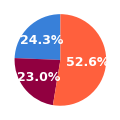

In [174]:
sizes = np.array([56, 53, 121])

fig1, ax1 = plt.subplots(figsize=(1.3,1.3))
ax1.pie(sizes, startangle=90,
        colors=['#3880d9', '#910040', '#ff603d'], autopct='%.1f%%', textprops={'color':"w", 'fontsize': 9, 'weight':'bold'})
ax1.axis('equal')

plt.savefig('fig/subjects.svg', dpi=500, bbox_inches='tight')

### Dropped features

In [176]:
set(df_cog.columns).difference(df_cog_.columns)

{'dccs01_acc',
 'dccs01_rt',
 'er4001_er40_c_ang',
 'er4001_er40_c_cr',
 'er4001_er40_c_fear',
 'er4001_er40_c_hap',
 'er4001_er40_c_noe',
 'er4001_er40_c_rtcr',
 'er4001_er40_c_sad',
 'flanker01_acc',
 'flanker01_rt',
 'lswmt01_nih_tlbx_agegencsc',
 'lswmt01_nih_tlbx_fctsc',
 'lswmt01_nih_tlbx_tscore',
 'orrt01_read_fcts',
 'pcps01_nih_tlbx_fctsc',
 'tpvt01_lavoc_screen',
 'tpvt01_tlbx_readncorr',
 'tpvt01_tpvt_fcts',
 'wasi201_iqscores_perfiq',
 'wasi201_iqscores_perfsumtscores',
 'wasi201_iqscores_verbconfintervalfrom',
 'wasi201_iqscores_verbconfintervalto',
 'wasi201_iqscores_verbiq',
 'wasi201_iqscores_verbpercentile',
 'wasi201_iqscores_verbsumtscores',
 'wasi201_ss_blockdesigntscoreperf4',
 'wasi201_ss_matrixreasoningtscore2',
 'wasi201_ss_matrixreasoningtscoreperf4',
 'wasi201_ss_similaritiestscoreverbal4',
 'wasi201_ss_vocabularytscore2',
 'wasi201_ss_vocabularytscoreverbal4',
 'wasi201_sumstscores_perf4subtest',
 'wasi201_sumstscores_total2subtest',
 'wasi201_sumstscores_tot

### Number of missing subjects

In [177]:
for column in df_cog_:
    print(column, df_cog_[column].isna().sum())

phenotype 0
phenotype_description 0
sex 0
interview_age 0
sestot 2
mot_edscale 7
cgi01_gaf2a 0
cgi01_gaf2b1 0
cgi01_gaf2b2 0
cgi01_gaf2c 0
cogcomp01_nih_fluidcogcomp_unadjusted 2
cogcomp01_nih_crycogcomp_unadjusted 0
dccs01_nih_dccs_ageadjusted 0
deldisk01_auc_200 1
deldisk01_auc_40000 1
flanker01_nih_flanker_ageadjusted 0
lswmt01_tbx_ls 0
orrt01_read_acss 0
pcps01_nih_patterncomp_ageadjusted 1
prang01_anger_ts_nih_toolbox_anger-physical_aggression_ff_age_18+_v2.0 3
prang01_anger_ts_nih_toolbox_anger-hostility_ff_age_18+_v2.0 3
prang01_anger_ts_nih_toolbox_anger-affect_cat_age_18+_v2.0 3
predd01_edd_rs 3
prsi01_soil_rs 0
psm01_nih_picseq_ageadjusted 1
pss01_pss_distress_rs 0
self_effic01_nih_tlbx_rawscore 0
tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_instrumental_support_ff_age_18+_v2.0 3
tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_emotional_support_ff_age_18+_v2.0 3
tlbx_friend01_nih_tlbx_rawscore 0
tlbx_perhost01_nih_tlbx_rawscore 0
tlbx_rej01_pr_score 0
tlbx_wellbeing01_tlbxpa_ts 3
tp

### Number of missing features

In [178]:
df_cog_.isnull().sum(axis=1)

src_subject_id
1048    0
1050    0
1051    0
1052    0
1053    0
1054    0
1056    0
1057    1
1058    0
1059    0
1060    0
1061    0
1063    4
1064    0
1065    0
1066    0
1067    0
1068    2
1069    0
1070    0
1071    0
1072    0
1073    0
1074    0
1075    0
1076    0
1077    0
1078    0
1079    0
1080    0
1081    0
1082    0
1083    0
1084    0
1085    0
1086    0
1087    0
1088    0
1089    0
1091    0
1093    0
1094    0
1095    0
1096    0
1098    0
1099    1
1100    0
1101    0
1103    0
1104    0
1105    0
1106    0
1107    0
1108    0
1109    0
1111    0
1112    0
1113    0
1114    0
1116    0
1117    0
1118    2
1119    0
1120    0
1121    0
1122    0
1123    0
1124    0
1126    0
1127    0
1128    0
1129    0
1130    0
1131    0
2001    0
2004    0
2005    7
2006    0
2007    7
2008    0
2010    0
2012    2
2013    0
2015    0
2016    0
2018    0
2019    0
2021    0
2022    0
2023    7
2029    0
2031    0
2033    0
2038    0
2040    0
2041    0
2042    0
2043    0
2046 

# Overview of Subjects

### Clinical Scores

In [35]:
from scipy.stats import kruskal
from scipy.stats import chi2_contingency

In [36]:
df_dem_cli = df_start.loc[df_cog_.index, ['phenotype', 'phenotype_description', 'sex', 'interview_age']]
convert(df_dem_cli)

In [37]:
df_dem_cli = df_dem_cli.join(socdem[['race']], how='left')

In [38]:
panss = pd.read_csv(path  + 'panss01.txt', sep="\t") #.replace(to_replace=np.NaN, value=0)
panss = panss.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
panss['src_subject_id'] = panss['src_subject_id'].astype(int)
panss = panss.set_index('src_subject_id')  # set index 

In [39]:
total = ['panss_total']
pos = ['pos_p1','pos_p2','pos_p3','pos_p4','pos_p5','pos_p6','pos_p7']
neg = ['neg_n1','neg_n2','neg_n3','neg_n4','neg_n5','neg_n6','neg_n7']
general = ['gps_g1','gps_g2','gps_g3','gps_g4','gps_g5','gps_g6','gps_g7','gps_g8','gps_g9','gps_g10','gps_g11','gps_g12','gps_g13','gps_g14','gps_g15','gps_g16']
all_panss = total + pos +neg + general

In [40]:
df_cli_all = df_start.loc[df_cog_.index, ['phenotype_description']]
df_cli_all = df_cli_all.join(panss[all_panss].astype(float))
convert(df_cli_all, True)
df_cli_all = df_cli_all[df_cli_all.phenotype_description != 0]

In [41]:
aff = df_cli_all.loc[df_cli_all['phenotype_description']==1]
nonaff = df_cli_all.loc[df_cli_all['phenotype_description']==2]

sig = []
for column in df_cli_all.columns[1:]:
    test = sci.stats.kruskal(ana.removenan(aff[column].values), ana.removenan(nonaff[column].values))
    sig.append([column, round(test[0],2), round(test[1],4)])
                             
df = pd.DataFrame(sig, columns= ['feature', 'A - NA stat', 'A - NA p'])
df = df.set_index('feature')

In [186]:
df
# *   P ≤ 0.05
# **  P ≤ 0.01
# *** P ≤ 0.001

,A - NA stat,A - NA p
feature,,
panss_total,12.65,0.0004
pos_p1,13.56,0.0002
pos_p2,4.96,0.0260
pos_p3,10.28,0.0013
pos_p4,1.74,0.1865
pos_p5,3.38,0.0661
pos_p6,0.52,0.4690
pos_p7,0.01,0.9086
neg_n1,5.79,0.0161


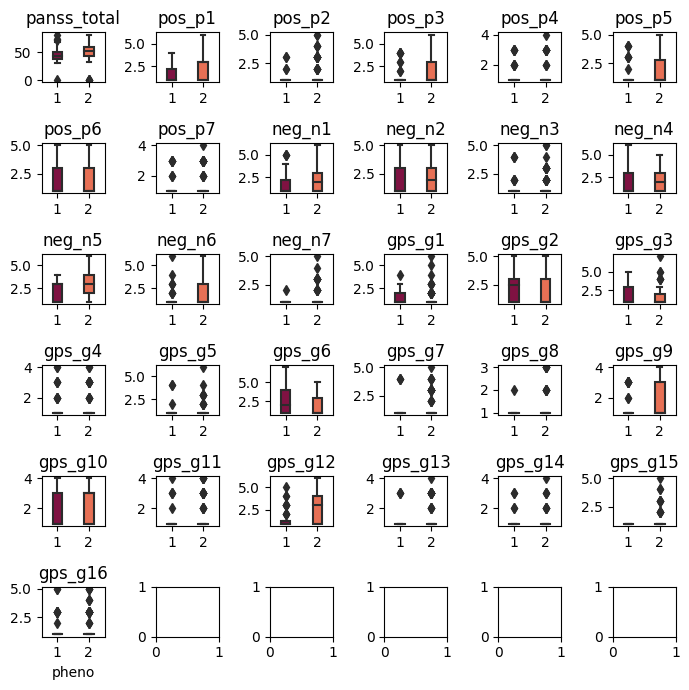

In [187]:
colors = ['#910040', '#ff603d']

fig, ax = plt.subplots(6,6, figsize=(7,7))
for i, col in enumerate(df_cli_all.columns[1:]):
    data = df_cli_all[['phenotype_description', col]]
    data = data.dropna(axis='rows')
    g = sns.boxplot(x='phenotype_description', y=col, data=data, palette=colors, width=0.3, ax=ax.flatten()[i])
    g.set(xlabel='')
    g.set(ylabel='')
    g.set(title=col)
    if i==30:
        g.set(xlabel='pheno')
    
plt.tight_layout()
plt.savefig('fig/panss_boxplot.svg', dpi=500, bbox_inches='tight')

In [188]:
df_dem_cli = df_dem_cli.join(panss[total].astype(float))

pos_df = panss[pos].astype(float)
pos_df['panss_pos'] = pos_df[pos].sum(axis=1)
df_dem_cli = df_dem_cli.join(pos_df['panss_pos'])

neg_df = panss[neg].astype(float)
neg_df['panss_neg'] = neg_df[neg].sum(axis=1)
df_dem_cli = df_dem_cli.join(neg_df['panss_neg'])

general_df = panss[general].astype(float)
general_df['general'] = general_df[general].sum(axis=1)
df_dem_cli = df_dem_cli.join(general_df['general'])

df_dem_cli['interview_age'] = df_dem_cli['interview_age'].div(12)

In [189]:
df_dem_cli.drop(columns=['sex','interview_age','race']).to_csv('../data/clinical.txt', sep=',')

In [190]:
# 1124 c but panss
# 2039 na but no panss

In [191]:
c = df_dem_cli.loc[df_dem_cli['phenotype_description']==0]
a = df_dem_cli.loc[df_dem_cli['phenotype_description']==1]
na = df_dem_cli.loc[df_dem_cli['phenotype_description']==2]
na = na.dropna(axis='rows')

In [192]:
df_dem_cli[['phenotype_description', 'interview_age', 'panss_total','panss_pos', 'panss_neg','general']].groupby('phenotype_description').mean()

,interview_age,panss_total,panss_pos,panss_neg,general
phenotype_description,,,,,
0,24.544643,57.000000,17.000000,18.000000,22.000000
1,23.631410,44.403846,10.038462,11.615385,23.403846
2,22.730226,50.211864,12.262712,14.008475,25.474576


In [193]:
df_dem_cli[['phenotype_description', 'interview_age', 'panss_total','panss_pos', 'panss_neg','general']].groupby('phenotype_description').std()

,interview_age,panss_total,panss_pos,panss_neg,general
phenotype_description,,,,,
0,4.418995,NaN,NaN,NaN,NaN
1,3.848943,12.867743,3.885425,4.661708,6.222223
2,3.375019,14.535457,4.589896,5.584618,5.685056


In [194]:
kruskal(c['interview_age'].values, a['interview_age'].values, na['interview_age'].values)

KruskalResult(statistic=7.247397910821306, pvalue=0.02668379156473103)

In [195]:
kruskal(a['panss_total'].values, na['panss_total'].values)

KruskalResult(statistic=12.406326651757864, pvalue=0.00042788171961633654)

In [196]:
kruskal(a['panss_pos'].values, na['panss_pos'].values)

KruskalResult(statistic=10.992173338149206, pvalue=0.0009149745307823757)

In [197]:
kruskal(a['panss_neg'].values, na['panss_neg'].values)

KruskalResult(statistic=9.051627153044635, pvalue=0.0026246113199827146)

In [198]:
kruskal(a['general'].values, na['general'].values)

KruskalResult(statistic=7.115986517695578, pvalue=0.007639955048999168)

### Demographics

In [199]:
df_dem_cli.groupby(['phenotype_description', 'sex']).size()

phenotype_description  sex
0                      0      37
                       1      19
1                      0      22
                       1      30
2                      0      82
                       1      36
dtype: int64

In [200]:
chi2_contingency([[37,19], [22,30], [82,36]])

Chi2ContingencyResult(statistic=11.796894710615254, pvalue=0.002743701506933287, dof=2, expected_freq=array([[34.9380531 , 21.0619469 ],
       [32.44247788, 19.55752212],
       [73.61946903, 44.38053097]]))

In [201]:
df_dem_cli.groupby(['phenotype_description', 'race']).size()

phenotype_description  race                         
0                      Asian                            10
                       Black or African American         6
                       More than one race                1
                       Unknown or not reported           2
                       White                            37
1                      American Indian/Alaska Native     1
                       Asian                             4
                       Black or African American         7
                       Hawaiian or Pacific Islander      1
                       More than one race                2
                       White                            37
2                      American Indian/Alaska Native     1
                       Asian                             6
                       Black or African American        52
                       Unknown or not reported           5
                       White                            53
dty

In [202]:
chi2_contingency([[10,6,37,0,0], [4,7,37,1,1], [6,52,53,1,0]])

Chi2ContingencyResult(statistic=37.47272616163364, pvalue=9.41879035016859e-06, dof=8, expected_freq=array([[ 4.93023256, 16.02325581, 31.30697674,  0.49302326,  0.24651163],
       [ 4.65116279, 15.11627907, 29.53488372,  0.46511628,  0.23255814],
       [10.41860465, 33.86046512, 66.15813953,  1.04186047,  0.52093023]]))

### Cognitive Features

In [31]:
cog_mean = df_cog_.drop(columns=['phenotype', 'sex', 'interview_age', 'sestot', 'mot_edscale']).groupby('phenotype_description').mean()
cog_std = df_cog_.drop(columns=['phenotype', 'sex', 'interview_age', 'sestot', 'mot_edscale']).groupby('phenotype_description').std()
cog_std = cog_std.add_suffix('_std') #make it differentiable
cog_mean_std = cog_mean.join(cog_std, how='left')
cog_mean_std = cog_mean_std.round(decimals=2)
cog_mean_std = cog_mean_std.astype(str)

In [32]:
cog_overview = pd.DataFrame()
for column in cog_mean:
    column_std = column + '_std'
    cog_overview[column] = cog_mean_std[[column, column_std]].apply(lambda x: ', '.join(x), axis=1)

In [33]:
cog_overview

,cgi01_gaf2a,cgi01_gaf2b1,cgi01_gaf2b2,cgi01_gaf2c,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,dccs01_nih_dccs_ageadjusted,deldisk01_auc_200,deldisk01_auc_40000,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,prang01_anger_ts_nih_toolbox_anger-physical_aggression_ff_age_18+_v2.0,prang01_anger_ts_nih_toolbox_anger-hostility_ff_age_18+_v2.0,prang01_anger_ts_nih_toolbox_anger-affect_cat_age_18+_v2.0,predd01_edd_rs,prsi01_soil_rs,psm01_nih_picseq_ageadjusted,pss01_pss_distress_rs,self_effic01_nih_tlbx_rawscore,tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_instrumental_support_ff_age_18+_v2.0,tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_emotional_support_ff_age_18+_v2.0,tlbx_friend01_nih_tlbx_rawscore,tlbx_perhost01_nih_tlbx_rawscore,tlbx_rej01_pr_score,tlbx_wellbeing01_tlbxpa_ts,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq,acpt01_%Hits,acpt01_RT
phenotype_description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,"87.88, 11.9","90.39, 7.62","1.38, 0.52","87.55, 11.35","112.34, 11.22","110.07, 8.11","98.95, 17.66","0.27, 0.26","0.55, 0.28","88.7, 13.79","19.18, 2.77","116.89, 17.21","104.32, 20.44","49.25, 9.15","52.14, 9.45","45.8, 10.62","9.34, 2.55","9.61, 3.75","106.71, 14.16","23.09, 6.21","19.48, 9.19","32.29, 6.27","34.25, 7.12","32.12, 6.39","14.55, 4.39","12.7, 4.63","49.45, 6.9","113.12, 15.11","43.41, 4.37","23.38, 2.58","115.25, 11.38","91.0, 6.89","623.19, 72.38"
1,"65.27, 18.51","68.12, 23.52","1.48, 0.7","75.12, 15.03","105.54, 10.9","107.37, 7.4","90.9, 15.23","0.27, 0.25","0.52, 0.33","78.71, 12.91","18.54, 2.32","109.58, 16.29","95.13, 24.02","55.43, 11.82","58.25, 8.9","52.8, 14.51","12.61, 8.2","15.17, 4.83","100.54, 17.59","30.4, 7.44","15.73, 8.81","28.41, 8.35","32.14, 6.34","25.35, 7.77","17.65, 7.22","17.15, 7.41","42.49, 8.83","109.71, 14.18","42.37, 5.11","22.21, 2.55","110.56, 11.49","86.33, 8.17","657.05, 89.39"
2,"61.83, 18.1","65.04, 23.27","1.79, 0.81","69.17, 15.18","97.61, 13.29","102.4, 10.46","83.81, 19.83","0.24, 0.26","0.39, 0.31","76.25, 17.11","16.45, 3.59","103.08, 21.05","89.94, 19.53","55.75, 10.92","57.43, 10.76","50.12, 14.04","11.53, 6.0","13.53, 5.31","89.52, 12.81","29.09, 6.37","15.98, 8.47","29.92, 8.36","30.47, 7.34","25.32, 8.36","17.36, 7.58","17.49, 7.53","44.02, 8.81","100.47, 17.87","38.68, 7.5","19.64, 4.54","100.96, 16.48","79.01, 14.51","674.5, 110.74"


#### Group comparison

In [206]:
df_subj_description = df_cog_[['phenotype', 'phenotype_description']].copy()
df_subj_description.to_csv('../data/subj_description.txt', sep=',')

In [207]:
data = df_cog_.drop(columns=['sex', 'interview_age', 'sestot', 'mot_edscale']).loc[df_subj_description['phenotype_description']==0]

In [208]:
cog_comparison = ana.group_comparison(df_cog_, cog_overview)
cog_comparison

,cgi01_gaf2a,cgi01_gaf2b1,cgi01_gaf2b2,cgi01_gaf2c,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,dccs01_nih_dccs_ageadjusted,deldisk01_auc_200,deldisk01_auc_40000,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,prang01_anger_ts_nih_toolbox_anger-physical_aggression_ff_age_18+_v2.0,prang01_anger_ts_nih_toolbox_anger-hostility_ff_age_18+_v2.0,prang01_anger_ts_nih_toolbox_anger-affect_cat_age_18+_v2.0,predd01_edd_rs,prsi01_soil_rs,psm01_nih_picseq_ageadjusted,pss01_pss_distress_rs,self_effic01_nih_tlbx_rawscore,tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_instrumental_support_ff_age_18+_v2.0,tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_emotional_support_ff_age_18+_v2.0,tlbx_friend01_nih_tlbx_rawscore,tlbx_perhost01_nih_tlbx_rawscore,tlbx_rej01_pr_score,tlbx_wellbeing01_tlbxpa_ts,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq,acpt01_%Hits,acpt01_RT
test,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
group,"[71.6159, 0.0]","[65.058, 0.0]","[11.75, 0.0028]","[64.8905, 0.0]","[46.1196, 0.0]","[23.732, 0.0]","[23.4622, 0.0]","[3.0634, 0.2162]","[13.3877, 0.0012]","[28.34, 0.0]","[30.1556, 0.0]","[17.7379, 0.0001]","[16.5251, 0.0003]","[14.4736, 0.0007]","[14.1971, 0.0008]","[7.0327, 0.0297]","[11.3003, 0.0035]","[37.5758, 0.0]","[49.5489, 0.0]","[36.6471, 0.0]","[12.7164, 0.0017]","[5.4181, 0.0666]","[13.4841, 0.0012]","[31.1382, 0.0]","[5.761, 0.0561]","[18.3357, 0.0001]","[23.2809, 0.0]","[23.1115, 0.0]","[19.9352, 0.0]","[34.7254, 0.0]","[34.7911, 0.0]","[43.5029, 0.0]","[8.7548, 0.0126]"
contr - affect.,"[38.825, 0.0]","[32.8331, 0.0]","[0.2071, 0.6082]","[26.6323, 0.0]","[8.6884, 0.0077]","[3.2747, 0.1299]","[4.9034, 0.0485]",-,"[0.1407, 0.5261]","[14.4792, 0.0007]","[0.9246, 0.4575]","[3.9861, 0.0729]","[4.6207, 0.0204]","[8.0241, 0.0073]","[11.816, 0.001]","[7.0082, 0.0103]","[9.4696, 0.0022]","[32.6482, 0.0]","[6.1923, 0.0163]","[25.0485, 0.0]","[8.2405, 0.0023]",-,"[5.0764, 0.0416]","[21.8273, 0.0]",-,"[10.1122, 0.0012]","[18.577, 0.0]","[1.8987, 0.2784]","[0.5613, 0.4725]","[5.2239, 0.0519]","[3.7562, 0.093]","[10.1902, 0.004]","[4.2567, 0.056]"
contr - non-aff.,"[67.5637, 0.0]","[63.26, 0.0]","[9.5017, 0.0021]","[60.2392, 0.0]","[42.3859, 0.0]","[20.3015, 0.0]","[21.395, 0.0]",-,"[11.9528, 0.0009]","[25.731, 0.0]","[22.7316, 0.0]","[16.3271, 0.0]","[17.2564, 0.0001]","[13.7903, 0.0002]","[10.733, 0.001]","[3.5005, 0.061]","[8.0241, 0.0055]","[23.8495, 0.0]","[45.6934, 0.0]","[30.9155, 0.0]","[11.2157, 0.0011]",-,"[12.7799, 0.0003]","[26.8489, 0.0]",-,"[17.4903, 0.0]","[17.9009, 0.0]","[18.5334, 0.0]","[16.0612, 0.0001]","[30.1583, 0.0]","[29.809, 0.0]","[40.613, 0.0]","[8.2634, 0.0039]"
affect - non-aff.,"[1.3214, 0.2873]","[0.7994, 0.341]","[5.3775, 0.0162]","[7.9369, 0.0118]","[12.5001, 0.0008]","[8.7481, 0.0052]","[6.2001, 0.0185]",-,"[5.5575, 0.0127]","[2.2984, 0.2027]","[16.1795, 0.0001]","[4.3483, 0.0485]","[1.3822, 0.2052]","[0.2593, 0.634]","[0.304, 0.5452]","[1.2732, 0.2532]","[0.7539, 0.3999]","[4.7273, 0.0358]","[15.1484, 0.0001]","[1.1682, 0.364]","[0.1874, 0.7331]",-,"[1.6289, 0.2457]","[0.027, 0.9731]",-,"[0.0646, 0.7697]","[0.7043, 0.4035]","[10.6137, 0.002]","[9.6666, 0.002]","[12.0238, 0.001]","[13.3756, 0.0004]","[9.9483, 0.0031]","[0.4922, 0.5332]"


In [209]:
cog_table = pd.concat([cog_overview, cog_comparison]).T
print(cog_table.to_latex(index=True))  

\begin{tabular}{llllllll}
\toprule
 & 0 & 1 & 2 & group & contr - affect. & contr - non-aff. & affect - non-aff. \\
\midrule
cgi01_gaf2a & 87.88, 11.9 & 65.27, 18.51 & 61.83, 18.1 & [71.6159, 0.0] & [38.825, 0.0] & [67.5637, 0.0] & [1.3214, 0.2873] \\
cgi01_gaf2b1 & 90.39, 7.62 & 68.12, 23.52 & 65.04, 23.27 & [65.058, 0.0] & [32.8331, 0.0] & [63.26, 0.0] & [0.7994, 0.341] \\
cgi01_gaf2b2 & 1.38, 0.52 & 1.48, 0.7 & 1.79, 0.81 & [11.75, 0.0028] & [0.2071, 0.6082] & [9.5017, 0.0021] & [5.3775, 0.0162] \\
cgi01_gaf2c & 87.55, 11.35 & 75.12, 15.03 & 69.17, 15.18 & [64.8905, 0.0] & [26.6323, 0.0] & [60.2392, 0.0] & [7.9369, 0.0118] \\
cogcomp01_nih_fluidcogcomp_unadjusted & 112.34, 11.22 & 105.54, 10.9 & 97.61, 13.29 & [46.1196, 0.0] & [8.6884, 0.0077] & [42.3859, 0.0] & [12.5001, 0.0008] \\
cogcomp01_nih_crycogcomp_unadjusted & 110.07, 8.11 & 107.37, 7.4 & 102.4, 10.46 & [23.732, 0.0] & [3.2747, 0.1299] & [20.3015, 0.0] & [8.7481, 0.0052] \\
dccs01_nih_dccs_ageadjusted & 98.95, 17.66 & 90.9

# Replacing missing data

In [48]:
#missing = ['phenotype','acpt01_%Hits', 'acpt01_RT','cogcomp01_nih_fluidcogcomp_unadjusted','pcps01_nih_patterncomp_ageadjusted','psm01_nih_picseq_ageadjusted']
missing = ['phenotype',
'cogcomp01_nih_fluidcogcomp_unadjusted',
'deldisk01_auc_200',
'deldisk01_auc_40000',
'pcps01_nih_patterncomp_ageadjusted',
'prang01_anger_ts_nih_toolbox_anger-physical_aggression_ff_age_18+_v2.0',
'prang01_anger_ts_nih_toolbox_anger-hostility_ff_age_18+_v2.0',
'prang01_anger_ts_nih_toolbox_anger-affect_cat_age_18+_v2.0',
'predd01_edd_rs',
'psm01_nih_picseq_ageadjusted',
'tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_instrumental_support_ff_age_18+_v2.0',
'tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_emotional_support_ff_age_18+_v2.0',
'tlbx_wellbeing01_tlbxpa_ts',
'acpt01_%Hits',
'acpt01_RT',]

In [49]:
miss_mean = df_cog_[missing].groupby('phenotype').mean()
miss_std = df_cog_[missing].groupby('phenotype').std()
miss_std = miss_std.add_suffix('_std') #make it differentiable
miss_mean_std = miss_mean.join(miss_std, how='left')
miss_mean_std = miss_mean_std.round(decimals=2)
miss_mean_std = miss_mean_std.astype(str)

In [50]:
miss_overview = pd.DataFrame()
for column in miss_mean:
    column_std = column + '_std'
    miss_overview[column] = miss_mean_std[[column, column_std]].apply(lambda x: ', '.join(x), axis=1)

In [214]:
print(df_cog_['mot_edscale'].loc[df_cog_['phenotype'].isin([1])].mode(1))
print(df_cog_['mot_edscale'].loc[df_cog_['phenotype'].isin([0])].mode(1))

0    6.0
Name: mot_edscale, dtype: float64
0    6.0
Name: mot_edscale, dtype: float64


In [215]:
print(df_cog_['sestot'].loc[df_cog_['phenotype'].isin([1])].mode(1))
print(df_cog_['sestot'].loc[df_cog_['phenotype'].isin([0])].mode(1))

0    2.0
Name: sestot, dtype: float64
0    2.0
Name: sestot, dtype: float64


In [216]:
mean_patients = df_cog_.drop(columns=['sestot', 'mot_edscale']).loc[df_cog_['phenotype'].isin([1])].mean()
mean_control = df_cog_.drop(columns=['sestot', 'mot_edscale']).loc[df_cog_['phenotype'].isin([0])].mean()

df_cog_.loc[df_cog_['phenotype'].isin([1])] = df_cog_.loc[df_cog_['phenotype'].isin([1])].fillna(mean_patients)
df_cog_.loc[df_cog_['phenotype'].isin([0])] = df_cog_.loc[df_cog_['phenotype'].isin([0])].fillna(mean_control)

In [217]:
df_cog_['sestot'] =  df_cog_['sestot'].fillna(2)
df_cog_['mot_edscale'] =  df_cog_['mot_edscale'].fillna(6)

## Medication

In [257]:
med = pd.read_csv(path  + 'mhx01.txt', sep="\t") #.replace(to_replace=np.NaN, value=0)
med = med.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
med['src_subject_id'] = med['src_subject_id'].astype(int)
med = med.set_index('src_subject_id')  # set index 

In [258]:
med_col = ['apd_exp_cat', 'apd_exp_months', 'apd_med', 'apd_chlor_equiv', 'apd_date_equiv']

'apd_exp_cat', Lifetime Antipsychotic Drug Exposure (categorical):
'apd_exp_months', Lifetime Antipsychotic Drug Exposure (in months):
'apd_med', Current Antipsychotic Medication (mg):
'apd_chlor_equiv', Chlorpromazine Equivalence (mg/d) of current antipsychotic drug:
'apd_date_equiv', Scan Date Chlorpromazine Equivalence of current antipsychotic drug (mg):

In [261]:
df_med = df_start.loc[df_cog_.index, ['phenotype_description']]
df_med = df_med.join(med[med_col].astype(float))
convert(df_med, True)
df_med.to_csv('../data/med.txt', sep=',')

In [262]:
df_med = df_med[df_med.phenotype_description != 0]

In [249]:
med_mean = df_med.groupby('phenotype_description').mean()
med_std = df_med.groupby('phenotype_description').std()
med_std = med_std.add_suffix('_std') #make it differentiable
med_mean_std = med_mean.join(med_std, how='left')
med_mean_std = med_mean_std.round(decimals=2)
med_mean_std = med_mean_std.astype(str)

In [252]:
med_overview = pd.DataFrame()
for column in med_mean:
    column_std = column + '_std'
    med_overview[column] = med_mean_std[[column, column_std]].apply(lambda x: ', '.join(x), axis=1)

In [253]:
med_overview

,apd_exp_cat,apd_exp_months,apd_med,apd_chlor_equiv,apd_date_equiv
phenotype_description,,,,,
1,"2.92, 1.32","6.55, 12.03","95.04, 165.77","60.78, 155.02","54.9, 151.41"
2,"3.55, 1.11","15.22, 15.03","104.33, 138.09","201.71, 233.41","191.1, 232.57"


## Brain network data

In [287]:
brain_data = pd.read_csv('../../earlypsychosis/anaBrain/brain_data_residual_cor.csv',  sep="\t", index_col=0, decimal=",", dtype={"HCP_ID": np.int32})

In [288]:
brain_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 1001 to 4024
Columns: 30 entries, 1 to 30
dtypes: float64(30)
memory usage: 42.9 KB


In [296]:
brain_data = brain_data.filter(items = df_cog_.index, axis=0)
brain_subj_description = brain_data.join(df_cog_['phenotype_description'], how='left')

In [293]:
brain_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 159 entries, 1093 to 1047
Columns: 30 entries, 1 to 30
dtypes: float64(30)
memory usage: 38.5 KB


In [298]:
brain_subj_description['phenotype_description'].value_counts()

phenotype_description
2    87
0    47
1    25
Name: count, dtype: int64

# Preprocessing

In [218]:
import sklearn.preprocessing as prepro

In [230]:
df_cog_.columns

Index(['phenotype', 'phenotype_description', 'sex', 'interview_age', 'sestot',
       'mot_edscale', 'cgi01_gaf2a', 'cgi01_gaf2b1', 'cgi01_gaf2b2',
       'cgi01_gaf2c', 'cogcomp01_nih_fluidcogcomp_unadjusted',
       'cogcomp01_nih_crycogcomp_unadjusted', 'dccs01_nih_dccs_ageadjusted',
       'deldisk01_auc_200', 'deldisk01_auc_40000',
       'flanker01_nih_flanker_ageadjusted', 'lswmt01_tbx_ls',
       'orrt01_read_acss', 'pcps01_nih_patterncomp_ageadjusted',
       'prang01_anger_ts_nih_toolbox_anger-physical_aggression_ff_age_18+_v2.0',
       'prang01_anger_ts_nih_toolbox_anger-hostility_ff_age_18+_v2.0',
       'prang01_anger_ts_nih_toolbox_anger-affect_cat_age_18+_v2.0',
       'predd01_edd_rs', 'prsi01_soil_rs', 'psm01_nih_picseq_ageadjusted',
       'pss01_pss_distress_rs', 'self_effic01_nih_tlbx_rawscore',
       'tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_instrumental_support_ff_age_18+_v2.0',
       'tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_emotional_support_ff_age_18+_v2

In [219]:
# features to be z-scored
df_cog_col = list(df_cog_.columns)[3:] # remove phenotype, phenotype_description, sex
del df_cog_col[1:3]  # remove 'sestot', 'mot_edscale'

In [220]:
df_cog_ = df_cog_.sort_values(by='phenotype_description')

### z-score

In [221]:
df_cog_zscore = df_cog_.copy()

for column in df_cog_col:
        df_cog_zscore[column] = (df_cog_zscore[column] - df_cog_zscore[column].mean()) / df_cog_zscore[column].std()

In [222]:
df_cog_zscore[column] = (df_cog_zscore[column] - df_cog_zscore[column].mean()) / df_cog_zscore[column].std()

In [223]:
for column in ['sestot', 'mot_edscale']:
        df_cog_zscore[column] = (df_cog_zscore[column] - df_cog_zscore[column].min()) / (df_cog_zscore[column].max()-df_cog_zscore[column].min())

In [224]:
df_cog_zscore.head(10)

,phenotype,phenotype_description,sex,interview_age,sestot,mot_edscale,cgi01_gaf2a,cgi01_gaf2b1,cgi01_gaf2b2,cgi01_gaf2c,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,dccs01_nih_dccs_ageadjusted,deldisk01_auc_200,deldisk01_auc_40000,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,prang01_anger_ts_nih_toolbox_anger-physical_aggression_ff_age_18+_v2.0,prang01_anger_ts_nih_toolbox_anger-hostility_ff_age_18+_v2.0,prang01_anger_ts_nih_toolbox_anger-affect_cat_age_18+_v2.0,predd01_edd_rs,prsi01_soil_rs,psm01_nih_picseq_ageadjusted,pss01_pss_distress_rs,self_effic01_nih_tlbx_rawscore,tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_instrumental_support_ff_age_18+_v2.0,tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_emotional_support_ff_age_18+_v2.0,tlbx_friend01_nih_tlbx_rawscore,tlbx_perhost01_nih_tlbx_rawscore,tlbx_rej01_pr_score,tlbx_wellbeing01_tlbxpa_ts,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq,acpt01_%Hits,acpt01_RT
src_subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1093,0,0,0,0.160231,0.50,0.833333,1.543346,0.777386,0.515424,1.235567,1.091573,-0.350522,0.404421,-0.660162,-0.348781,-0.548597,1.008516,-0.904550,0.663257,-1.100729,-0.812953,-0.792366,0.126629,-1.323502,2.217330,-1.107210,0.023561,1.242671,1.006534,1.326069,-1.260515,-1.148202,1.724561,-0.042461,0.494897,0.454052,0.404643,0.578651,-1.352407
4063,0,0,0,-0.079441,0.25,0.833333,0.794749,0.344761,-0.823494,0.614900,0.358640,0.464058,0.715127,-0.238762,-0.658848,0.129579,1.008516,-0.050043,-0.403962,-0.006038,0.067507,-0.792366,-0.537316,-0.369703,0.165889,-0.407072,-0.429618,-1.283336,-1.367300,0.481187,-0.249803,0.247676,-0.346533,0.998095,0.045111,0.700133,0.211712,-0.002171,-0.696658
1084,0,0,0,0.312750,0.00,1.000000,1.543346,1.210012,0.515424,1.545900,-0.007826,1.176816,-0.165206,-0.212806,1.599675,-1.226774,0.117025,1.055791,0.663257,-1.100729,-0.128151,-0.123850,0.126629,-1.323502,0.228054,-1.247238,0.590035,1.242671,1.146171,1.205372,-0.249803,-1.148202,1.264318,0.998095,0.944682,0.700133,0.983436,0.446646,0.226123
1085,0,0,0,0.922825,0.00,1.000000,1.293814,0.993699,-0.823494,1.545900,0.065467,1.380461,0.766911,-0.200083,-0.425985,0.191232,0.414188,1.357381,-1.099975,0.176411,-1.008610,-0.420968,-0.205343,-1.132742,0.290219,-0.827155,-0.316323,0.863770,1.146171,0.119095,0.183359,-1.008614,-0.116411,1.229330,0.644825,1.438376,1.240678,1.106670,1.013698
3039,0,0,0,1.511112,0.50,0.500000,0.944469,0.907174,-0.823494,0.614900,-0.154412,-0.452344,-0.320558,2.850996,1.624714,0.992713,-0.477303,0.201283,-0.264760,-0.188486,-1.302097,-0.643807,-0.039357,-0.941982,0.352384,-1.247238,1.043214,0.737469,1.146171,1.084674,-0.827353,-1.008614,0.343832,-1.140826,-0.404674,0.700133,-0.109840,0.974665,0.195702
3038,0,0,0,0.138443,0.25,0.666667,0.944469,0.907174,-0.823494,0.614900,2.117678,0.056768,1.284754,-0.425542,-0.704336,0.437841,1.900007,0.201283,1.684076,-1.100729,-0.617295,-1.238044,0.126629,-0.751222,2.528154,-1.667321,0.929920,-0.146633,0.866896,1.205372,-1.260515,-0.729439,0.573953,0.015347,0.944682,1.438376,1.755161,1.212274,-0.666236
1088,0,0,0,0.748518,0.00,1.000000,1.543346,1.210012,0.515424,1.545900,0.578520,0.464058,1.077617,-0.370577,0.028474,-0.486945,0.117025,0.754200,0.477654,0.632532,-1.204268,-0.123850,0.292616,-0.751222,0.911868,-0.827155,-0.316323,0.358568,1.146171,1.567464,0.616522,-0.171088,1.379379,0.246582,0.944682,1.192295,1.176367,0.763457,0.270065
3036,0,0,1,-1.321379,0.00,1.000000,0.694936,0.690861,0.515424,0.801100,0.944986,-0.655989,-0.320558,2.850996,1.684808,0.314536,0.414188,-0.954815,0.013645,-1.100729,1.045796,0.247548,-0.869289,-0.560463,2.341660,-0.127016,2.516046,0.358568,0.447985,1.567464,0.760909,-0.031500,1.264318,-0.389313,0.344968,0.700133,0.661884,1.133071,0.290346
1091,0,0,0,-0.733093,0.00,1.000000,1.543346,1.210012,-0.823494,1.545900,0.285347,1.278639,-1.149107,1.333345,0.830976,0.684451,1.008516,1.106

### Quantile Normalization

In [225]:
df = df_cog_[['phenotype', 'phenotype_description', 'sex', 'sestot', 'mot_edscale']].copy()
df_ = df_cog_.drop(columns=['phenotype', 'phenotype_description', 'sex', 'sestot', 'mot_edscale'])

qt = prepro.QuantileTransformer(n_quantiles=100)
q_features = qt.fit_transform(df_)
df_cog_quant = pd.DataFrame(data=q_features, index=df_cog_.index, columns=df_cog_col, dtype=float)

df_cog_quant = df.join(pd.DataFrame(df_cog_quant))

In [226]:
for column in ['sestot', 'mot_edscale']:
        df_cog_quant[column] = (df_cog_[column] - df_cog_[column].min()) / (df_cog_[column].max()-df_cog_zscore[column].min())

In [227]:
df_cog_quant.head()

,phenotype,phenotype_description,sex,sestot,mot_edscale,interview_age,cgi01_gaf2a,cgi01_gaf2b1,cgi01_gaf2b2,cgi01_gaf2c,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,dccs01_nih_dccs_ageadjusted,deldisk01_auc_200,deldisk01_auc_40000,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,prang01_anger_ts_nih_toolbox_anger-physical_aggression_ff_age_18+_v2.0,prang01_anger_ts_nih_toolbox_anger-hostility_ff_age_18+_v2.0,prang01_anger_ts_nih_toolbox_anger-affect_cat_age_18+_v2.0,predd01_edd_rs,prsi01_soil_rs,psm01_nih_picseq_ageadjusted,pss01_pss_distress_rs,self_effic01_nih_tlbx_rawscore,tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_instrumental_support_ff_age_18+_v2.0,tlbx_emsup01_nih_tlbx_rawscore_nih_toolbox_emotional_support_ff_age_18+_v2.0,tlbx_friend01_nih_tlbx_rawscore,tlbx_perhost01_nih_tlbx_rawscore,tlbx_rej01_pr_score,tlbx_wellbeing01_tlbxpa_ts,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq,acpt01_%Hits,acpt01_RT
src_subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1093,0,0,0,0.4,0.714286,0.631313,1.000000,0.777778,0.69697,0.939394,0.883838,0.333333,0.671717,0.299176,0.411597,0.348485,0.848485,0.222222,0.757576,0.000000,0.191919,0.202020,0.661616,0.106061,0.959820,0.126263,0.681818,1.000000,0.787879,0.898990,0.000000,0.085859,0.939394,0.444444,0.661616,0.646465,0.616162,0.717135,0.072660
4063,0,0,0,0.2,0.714286,0.525253,0.702020,0.484848,0.00000,0.676768,0.646465,0.651515,0.757576,0.555556,0.343305,0.555556,0.848485,0.494949,0.333333,0.505051,0.459596,0.202020,0.262626,0.393939,0.606061,0.328283,0.398990,0.116162,0.111111,0.651515,0.419192,0.656566,0.353535,0.833333,0.429293,0.747475,0.563492,0.393939,0.248910
1084,0,0,0,0.0,0.857143,0.692424,1.000000,1.000000,0.69697,1.000000,0.429293,0.893939,0.459596,0.576520,0.922261,0.111111,0.530303,0.838384,0.757576,0.000000,0.383838,0.474747,0.661616,0.106061,0.646465,0.090909,0.838384,1.000000,1.000000,0.858586,0.419192,0.085859,0.898990,0.833333,0.853535,0.747475,0.818182,0.601010,0.652718
1085,0,0,0,0.0,0.857143,0.850422,0.909091,0.909091,0.00000,1.000000,0.469697,0.939394,0.777778,0.588322,0.391507,0.575758,0.681818,0.919192,0.134921,0.540404,0.161616,0.318182,0.419192,0.146465,0.666667,0.217172,0.474747,0.767677,1.000000,0.540404,0.656566,0.202020,0.474747,0.898990,0.732323,0.974747,0.909091,0.939394,0.857807
3039,0,0,0,0.4,0.428571,0.920569,0.762626,0.843434,0.00000,0.676768,0.373737,0.297980,0.398990,1.000000,0.929293,0.813131,0.272727,0.540404,0.383838,0.439394,0.126984,0.247475,0.500000,0.186869,0.676768,0.090909,0.868687,0.737374,1.000000,0.823232,0.217172,0.202020,0.621212,0.151515,0.277778,0.747475,0.414141,0.868687,0.637681


# Saving Dataframes

In [228]:
df_cog_zscore = df_cog_zscore.drop(columns=['phenotype', 'phenotype_description'])
df_cog_quant = df_cog_quant.drop(columns=['phenotype', 'phenotype_description'])

df_subj_description = df_cog_[['phenotype', 'phenotype_description']].copy()

In [229]:
df_cog_.drop(columns=['phenotype', 'phenotype_description']).to_csv('../data/cog_data.txt', sep=',')
df_subj_description.to_csv('../data/subj_description.txt', sep=',')

df_cog_zscore.to_csv('../data_zscore/cog_data.txt', sep=',')
df_subj_description.to_csv('../data_zscore/subj_description.txt', sep=',')

df_cog_quant.to_csv('../data_quant/cog_data.txt', sep=',')
df_subj_description.to_csv('../data_quant/subj_description.txt', sep=',')

In [299]:
brain_data.to_csv('../data/braindata.txt', sep=',')
brain_subj_description.to_csv('../data/brain_subj_description.txt', sep=',')